In [1]:
import os
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
import lightgbm as lgb

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/new-york-city-taxi-fare-prediction/sample_submission.csv
/kaggle/input/new-york-city-taxi-fare-prediction/GCP-Coupons-Instructions.rtf
/kaggle/input/new-york-city-taxi-fare-prediction/train.csv
/kaggle/input/new-york-city-taxi-fare-prediction/test.csv
/kaggle/input/nyc-map-mask/nyc_-74.3_-73.7_40.5_40.9.png
/kaggle/input/nyc-map-mask/nyc_mask-74.5_-72.8_40.5_41.8.png
/kaggle/input/nyc-map-mask/mask.png


## Read data

In [2]:
train_df = pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/train.csv',nrows=12000000)
test_df = pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/test.csv')

## Remove missing data



In [3]:
print(train_df.isnull().sum())
train_df = train_df.drop(train_df.loc[train_df.isnull().any(axis=1)].index, axis=0)

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    79
dropoff_latitude     79
passenger_count       0
dtype: int64


## Remove 'fare_amount'< 0

In [4]:
print(len(train_df.loc[train_df['fare_amount'] < 0]))
train_df = train_df.drop(train_df.loc[train_df['fare_amount'] < 0].index, axis = 0)

494


## Remove passengers > 7 and < 1

In [5]:
print(len(train_df.loc[train_df['passenger_count'] > 7]))
print(len(train_df.loc[train_df['passenger_count'] < 1]))

train_df = train_df.drop(train_df.loc[train_df['passenger_count'] > 7].index, axis = 0)
train_df = train_df.drop(train_df.loc[train_df['passenger_count'] < 1].index, axis = 0)

20
42279


## Drop out the position outside the New York City

In [6]:
lat_lon = [-74.5, -72.8, 40.5, 41.8]
print(len(train_df.loc[(train_df['pickup_longitude'] < lat_lon[0]) | (train_df['pickup_longitude'] > lat_lon[1]) | (train_df['pickup_latitude'] < lat_lon[2]) | (train_df['pickup_latitude'] > lat_lon[3])]))
train_df = train_df.drop(train_df.loc[train_df['pickup_longitude'] < lat_lon[0]].index, axis=0)
train_df = train_df.drop(train_df.loc[train_df['pickup_longitude'] > lat_lon[1]].index, axis=0)
train_df = train_df.drop(train_df.loc[train_df['pickup_latitude'] < lat_lon[2]].index, axis=0)
train_df = train_df.drop(train_df.loc[train_df['pickup_latitude'] > lat_lon[3]].index, axis=0)


240636


In [7]:
print(len(train_df.loc[(train_df['dropoff_longitude'] < lat_lon[0]) | (train_df['dropoff_longitude'] > lat_lon[1]) | (train_df['dropoff_latitude'] < lat_lon[2]) | (train_df['dropoff_latitude'] > lat_lon[3])]))
train_df = train_df.drop(train_df.loc[train_df['dropoff_longitude'] < lat_lon[0]].index, axis=0)
train_df = train_df.drop(train_df.loc[train_df['dropoff_longitude'] > lat_lon[1]].index, axis=0)
train_df = train_df.drop(train_df.loc[train_df['dropoff_latitude'] < lat_lon[2]].index, axis=0)
train_df = train_df.drop(train_df.loc[train_df['dropoff_latitude'] > lat_lon[3]].index, axis=0)

12930


## Remove fare amount < 2.5 and >500

In [8]:
print(len(train_df.loc[train_df['fare_amount'] < 2.5]))
train_df = train_df.drop(train_df.loc[train_df['fare_amount'] < 2.5].index, axis = 0)
train_df = train_df.drop(train_df.loc[train_df['fare_amount'] > 500].index, axis = 0)

399


## Remove some locations on water

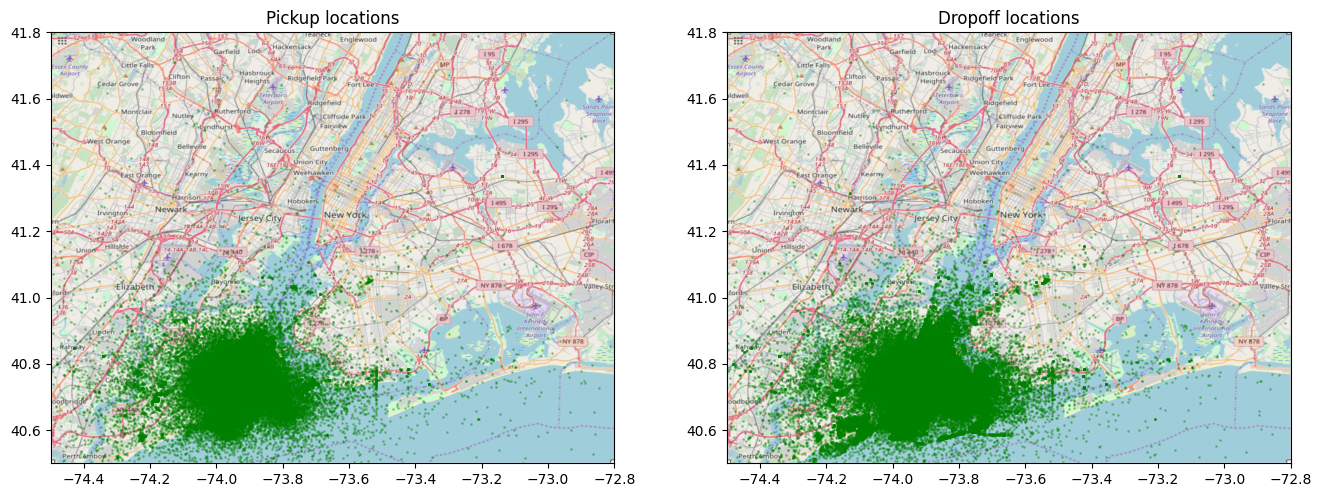

In [9]:
box = (-74.5, -72.8, 40.5, 41.8)
def plot_geodata(df, box, nyc_map, s=10, alpha=0.2):
  fig, axs = plt.subplots(1, 2, figsize=(16,10))
  axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='g', s=s)
  axs[0].set_xlim((box[0], box[1]))
  axs[0].set_ylim((box[2], box[3]))
  axs[0].set_title('Pickup locations')
  axs[0].imshow(nyc_map, zorder=0, extent=box)

  axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='g', s=s)
  axs[1].set_xlim((box[0], box[1]))
  axs[1].set_ylim((box[2], box[3]))
  axs[1].set_title('Dropoff locations')
  axs[1].imshow(nyc_map, zorder=0, extent=box)

def select_within_boundingbox(df, box):
  return (df.pickup_longitude >= box[0]) & (df.pickup_longitude <= box[1]) & \
           (df.pickup_latitude >= box[2]) & (df.pickup_latitude <= box[3]) & \
           (df.dropoff_longitude >= box[0]) & (df.dropoff_longitude <= box[1]) & \
           (df.dropoff_latitude >= box[2]) & (df.dropoff_latitude <= box[3])

def lonlat_to_xy(longitude, latitude, dx, dy, box):
  return (dx*(longitude - box[0])/(box[1]-box[0])).astype('int'), \
              (dy - dy*(latitude - box[2])/(box[3]-box[2])).astype('int')

def remove_datapoints_from_water(df):
  # define bounding box
  box = (-74.5, -72.8, 40.5, 41.8)
    
  # read nyc mask and turn into boolean map with
  # land = True, water = False
  nyc_mask = plt.imread('/kaggle/input/nyc-map-mask/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9
    
  # calculate for each lon,lat coordinate the xy coordinate in the mask map
  pickup_x, pickup_y = lonlat_to_xy(df['pickup_longitude'], df['pickup_latitude'], 
                                      nyc_mask.shape[1], nyc_mask.shape[0], box)
  dropoff_x, dropoff_y = lonlat_to_xy(df['dropoff_longitude'], df['dropoff_latitude'], 
                                      nyc_mask.shape[1], nyc_mask.shape[0], box)  
  # calculate boolean index
  idx = (nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x])
    
  # return only datapoints on land
  return df[idx]
image = plt.imread('/kaggle/input/nyc-map-mask/nyc_-74.3_-73.7_40.5_40.9.png')
nyc_map = image
plot_geodata(train_df, box, nyc_map, s=1, alpha=0.3)

Old size: 11703160
New size: 11700720


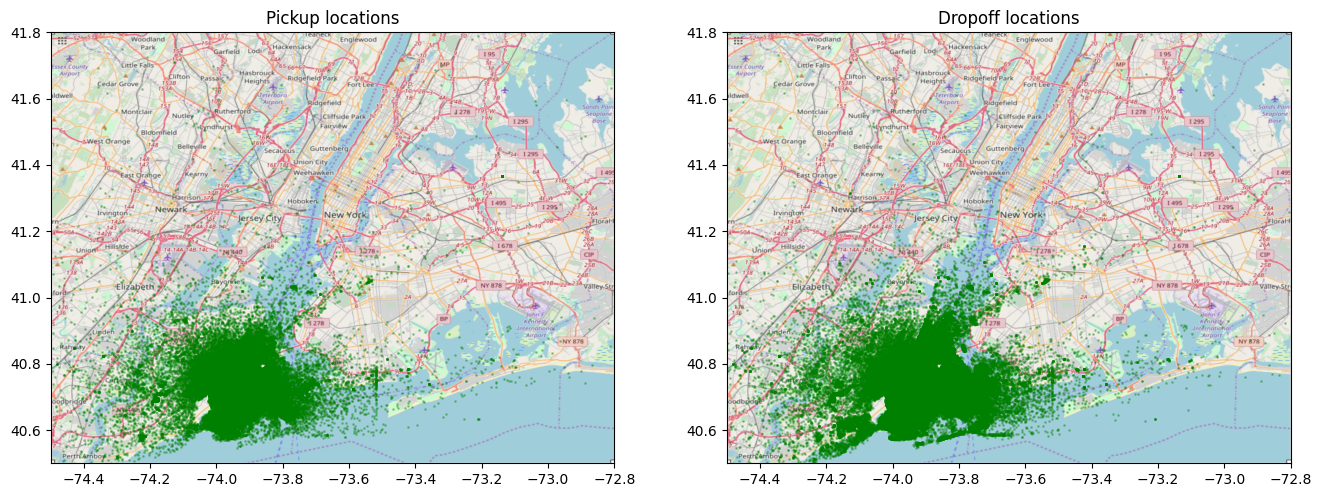

In [10]:

train_df = train_df[select_within_boundingbox(train_df, box)]

print('Old size: %d' % len(train_df))
train_df = remove_datapoints_from_water(train_df)
print('New size: %d' % len(train_df))

image = plt.imread('/kaggle/input/nyc-map-mask/nyc_-74.3_-73.7_40.5_40.9.png')
nyc_map = image

plot_geodata(train_df, box, nyc_map, s=1, alpha=0.3)

## Process time features

In [11]:
def time_features(df):
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df["year"] = df['pickup_datetime'].dt.year
    df["month"] = df['pickup_datetime'].dt.month
    df["weekday"] = df['pickup_datetime'].dt.weekday
    df["hour"] = df['pickup_datetime'].dt.hour
    return df

train = time_features(train_df)
test = time_features(test_df)

## Calculate Haversine distance

In [12]:
def haversine_distance(lat1, long1, lat2, long2, dataset):
    R = 6371  #radius of earth in kilometers
    phi1 = np.radians(dataset[lat1])
    phi2 = np.radians(dataset[lat2])
    delta_phi = np.radians(dataset[lat2] - dataset[lat1])
    delta_lambda = np.radians(dataset[long2] - dataset[long1])
    
    #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
    #c = 2 * atan2( √a, √(1−a) )
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    #d = R*c
    d = (R * c) #in kilometers
    dataset['H_Distance'] = d
    return dataset

train = haversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', train)
test = haversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', test)


## Caluculate Chebyshev

In [13]:
def chebyshev(pickup_long, dropoff_long, pickup_lat, dropoff_lat):
    return np.maximum(np.absolute(pickup_long - dropoff_long), np.absolute(pickup_lat - dropoff_lat))

train['Chebyshev'] = chebyshev(train['pickup_longitude'], train['dropoff_longitude'], train['pickup_latitude'], train['dropoff_latitude'])
test['Chebyshev'] = chebyshev(test['pickup_longitude'], test['dropoff_longitude'], test['pickup_latitude'], test['dropoff_latitude'])

## Calculate Manhattan distance

In [14]:
def manhattan_distance(pickup_long, dropoff_long, pickup_lat, dropoff_lat):
    return abs(pickup_long - dropoff_long) + abs(pickup_lat - dropoff_lat)

train['Manhattan'] = chebyshev(train['pickup_longitude'], train['dropoff_longitude'], train['pickup_latitude'], train['dropoff_latitude'])
test['Manhattan'] = chebyshev(test['pickup_longitude'], test['dropoff_longitude'], test['pickup_latitude'], test['dropoff_latitude'])

## Calculate Haversine bearing

In [15]:
from math import radians, cos, sin, asin, sqrt, atan2, degrees

def haversine_bearing(lat1, long1, lat2, long2, dataset):
    lat1 = np.radians(dataset[lat1])
    long1 = np.radians(dataset[long1])
    lat2 = np.radians(dataset[lat2])
    long2 = np.radians(dataset[long2])

    diffLat = lat2 - lat1
    diffLong = long2 - long1

    x = np.sin(diffLong) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(diffLong))

    initial_bearing = np.arctan2(x, y)
    initial_bearing = np.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    dataset['H_bearing'] = compass_bearing
    
    return dataset

train = haversine_bearing('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', train)
test = haversine_bearing('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', test)

## Add popular landmark
- JFK Airport: Longitude -73.7781, Latitude 40.6413  
- LGA Airport: Longitude -73.8740, Latitude 40.7769  
- EWR Airport: Longitude -74.1745, Latitude 40.6895  


In [16]:
def haversine_np(lon1, lat1, lon2, lat2): 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

jfk_lonlat = -73.7781, 40.6413
lga_lonlat = -73.8740, 40.7769
ewr_lonlat = -74.1745, 40.6895


def add_landmark_dropoff_distance(df, landmark_name, landmark_lonlat):
    lon, lat = landmark_lonlat
    df[landmark_name + '_drop_distance'] = haversine_np(lon, lat, df['dropoff_longitude'], df['dropoff_latitude']);

def add_landmark_pickup_distance(df, landmark_name, landmark_lonlat):
    lon, lat = landmark_lonlat
    df[landmark_name + '_pickup_distance'] = haversine_np(lon, lat, df['pickup_longitude'], df['pickup_latitude']);    
    
    
for a_df in [train, test]:
    for name, lonlat in [('jfk', jfk_lonlat), ('lga', lga_lonlat), ('ewr', ewr_lonlat)]:
        add_landmark_dropoff_distance(a_df, name, lonlat)
        add_landmark_pickup_distance(a_df, name, lonlat)

## Remove the items no need
'key' 'pickup_datetime'

In [17]:
train = train.drop('key', axis=1)
train = train.drop('pickup_datetime', axis=1)
test = test.drop('key', axis=1)
test = test.drop('pickup_datetime', axis=1)

## Split data

In [18]:
X = train.iloc[:,train.columns != "fare_amount"]
y = train["fare_amount"]
X_test = test
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42, shuffle=True)


## LightGBM model

In [19]:
'''
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 1000,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    #'device_type':'gpu'
}
'''
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
    }


def LGBmodel(params,X_train,y_train,X_valid,y_valid):
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    #model = lgb.train(params, lgb_train, num_boost_round=2000, valid_sets=lgb_eval,early_stopping_rounds=50)
    model = lgb.train(params, lgb_train, num_boost_round=50000, valid_sets=lgb_eval,early_stopping_rounds=500, verbose_eval=500)
    return model

model = LGBmodel(params,X_train,y_train,X_valid,y_valid)

lgb_model = model
y = lgb_model.predict(X_test)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.632338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70059
[LightGBM] [Info] Number of data points in the train set: 9360576, number of used features: 19
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Start training from score 11.325206
Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 3.56675
[1000]	valid_0's rmse: 3.51522
[1500]	valid_0's rmse: 3.49323
[2000]	valid_0's rmse: 3.48174
[2500]	valid_0's rmse: 3.47461
[3000]	valid_0's rmse: 3.46896
[3500]	valid_0's rmse: 3.46465
[4000]	valid_0's rmse: 3.46144
[45

## Submission.csv

In [20]:
submission = pd.DataFrame()
submission['key'] = test_df['key']
submission['fare_amount'] = y
submission.to_csv('submission.csv', index=False)